In [2]:
! pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print('The dataset is extracted')

The dataset is extracted


In [6]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Load the dataset
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

print(twitter_data.shape)
print(twitter_data.head())

# Assigning column names
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data.columns = column_names

print(twitter_data.shape)
print(twitter_data.head())

(1599999, 6)
   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all..

In [9]:
# Checking for missing values
print(twitter_data.isnull().sum())

# Checking the distribution of target values
print(twitter_data['target'].value_counts())

# Replace=ing sentiment label 4 with 1 for positive sentiment
twitter_data.replace({'target': {4: 1}}, inplace=True)

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64
target
4    800000
0    799999
Name: count, dtype: int64


In [10]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

def preprocess_text(text):
    text = clean_text(text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [11]:
twitter_data['processed_text'] = twitter_data['text'].apply(preprocess_text)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(twitter_data['processed_text'])

y = twitter_data['target']

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')


Training data shape: (1279999, 388479)
Test data shape: (320000, 388479)


In [14]:
# Logistic Regression - Training and Prediction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

print(f'Logistic Regression Accuracy: {accuracy_logistic}')
print('Classification Report:')
print(classification_report(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.77919375
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159494
           1       0.77      0.80      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [15]:
# Naives Bayes - Training and Prediction
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(f'Naive Bayes Accuracy: {accuracy_nb}')
print('Classification Report:')
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.7589
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76    159494
           1       0.77      0.74      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



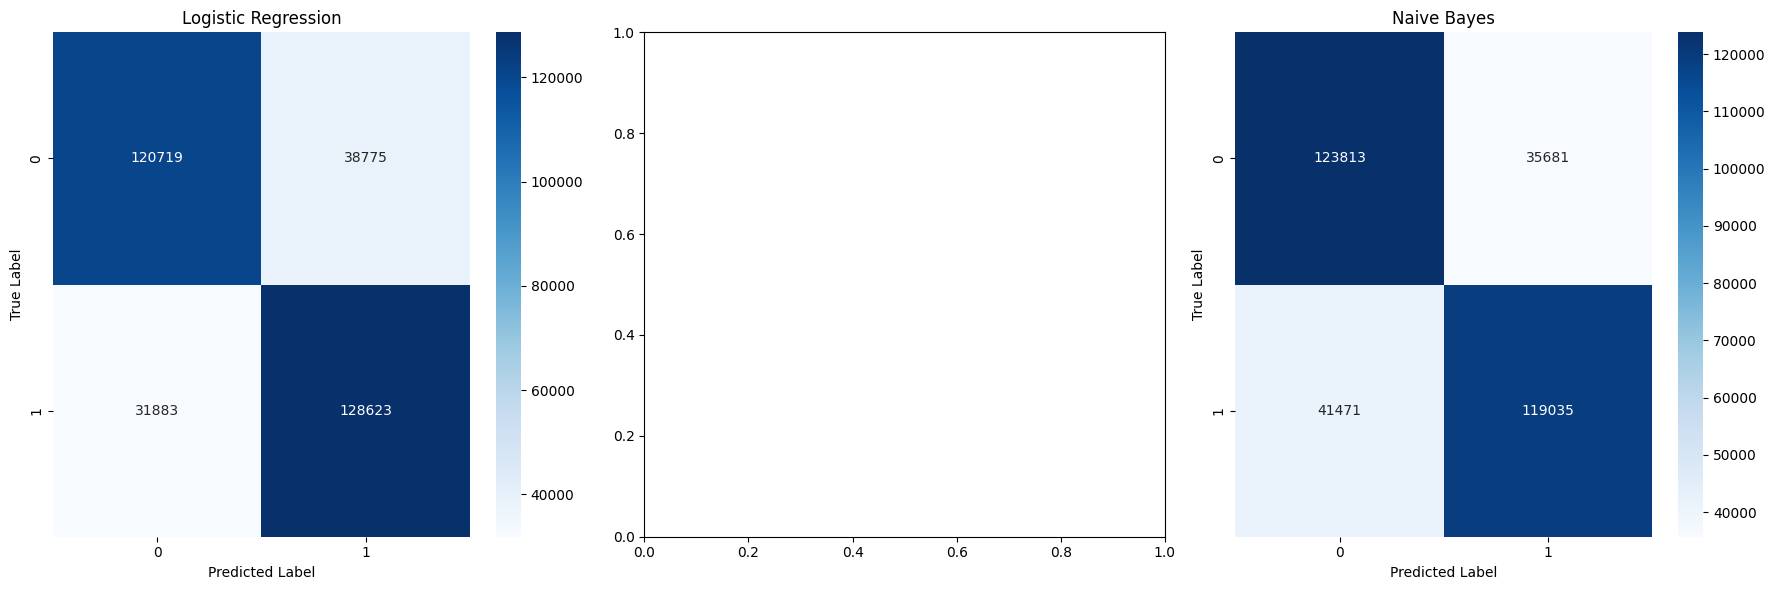

In [21]:
# Plotting Confusion Matrices
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

cm_logistic = confusion_matrix(y_test, y_pred_logistic)
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Naive Bayes')
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()


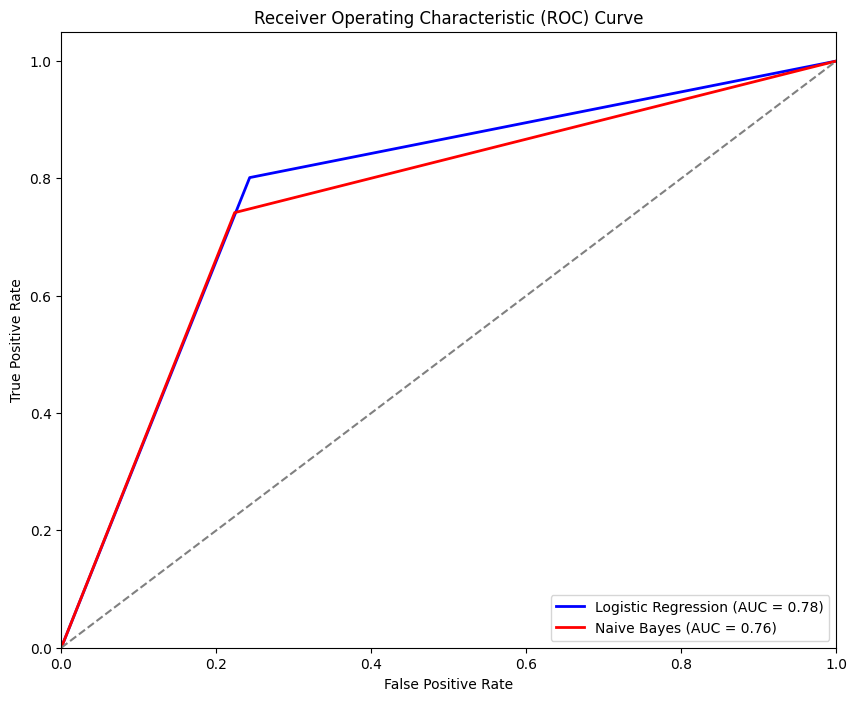

In [23]:
# Plotting ROC Curves
from sklearn.metrics import roc_curve, auc

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logistic)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()